In [2]:
import magnonRPA as rpa
import numpy as np

from matplotlib import pyplot as plt 
from matplotlib import colors as mclr
from matplotlib import colormaps as cmaps

import time

### Plotting settings 
#plt.rc('figure', dpi=100)
#plt.rc('figure',figsize=(4,1.7))
plt.rc('font', family = 'Times New Roman')
plt.rc('font', size = 14)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=18)
plt.rc('lines', linewidth=2.5)

saveFigs = False ### Option to save figures or not 

figDirectory = "../figures/06022025/" ### Figures are stored in this folder
dataDirectory = "../data/" ### Data is loaded from and stored to this folder


## Load in spectral function and plot it 

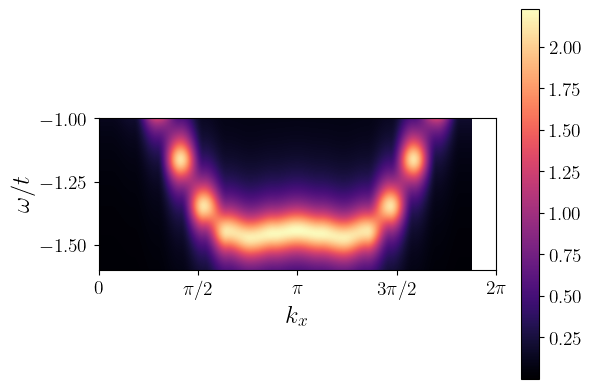

In [61]:
#holesDirectory = dataDirectory+"hole_spectra/05052025/5ksamples/" 
#holesFile = holesDirectory+"jon_request_0.5" 
holesDirectory = dataDirectory+"hole_spectra/06062025/16x16eta=0.09/"
holesFile = holesDirectory+"sr_3.pkl"
Jh = 0.5

f_spec = rpa.fermion_spectra()
f_spec.load_hole_spectrum(holesFile)

f_spec.plot_spectrum([-1.6,-1.],cmap='magma',aspect=4.)

## Compute doping vs chemical potential and plot it 

In [62]:
mus = np.linspace(-2.5*rpa.t,-1.*rpa.t,30)
Ts = np.array([0.001*rpa.t])
f_spec.calc_doping(mus,Ts)

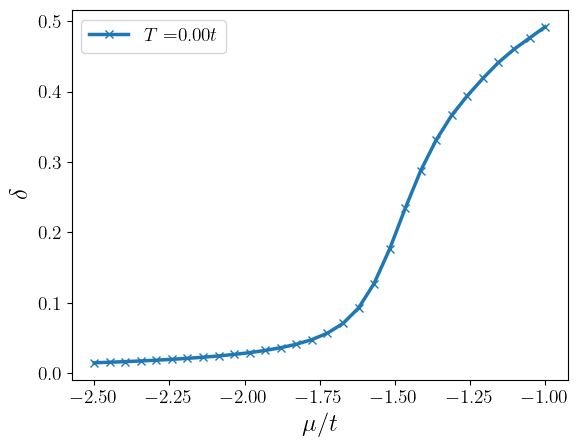

In [63]:
for i in range(len(Ts)):
    plt.plot(f_spec.mus,f_spec.dopings[:,i],label=r'$T = ${T:0.2f}$t$'.format(T=Ts[i]),marker='x')
plt.xlabel(r'$\mu/t$')
plt.ylabel(r'$\delta$')
plt.legend()
plt.show()

## Set parameters and computing doping

In [80]:
U = 8.*rpa.t ### Hubbard U (used to compute J)
J = 4.*rpa.t**2/U ### Superexchange J
T = 0.001*rpa.t
print("J/t used in LSWT: {jt:0.2f}".format(jt=J/rpa.t))

delta = 0.08
mu_indx = np.argmin(np.abs(f_spec.dopings-delta))
print("Doping: {d:0.1%}".format(d=f_spec.dopings[mu_indx,0]))

J/t used in LSWT: 0.50
Doping: 7.1%


## Now we compute the RPA kernel and magnon propagator

In [81]:
### Calculate RPA spectra from hole spectra 
t0 = time.time()

ImPi = rpa.calc_ImPi(f_spec.kxs,f_spec.kys,f_spec.ws,f_spec.A,f_spec.mu_grid[mu_indx,0],T)

t1 = time.time()
KK_matrix = rpa.KK_matrix(f_spec.ws)
Pi = rpa.Kramers_Kronig_precomputed(KK_matrix,ImPi)

t2 = time.time()


print("Time for RPA: ",t1-t0,"s")
print("Time for Kramers-Kronig: ",t2-t1,"s")

Time for RPA:  4.518072128295898 s
Time for Kramers-Kronig:  18.688939809799194 s


In [83]:
t2 = time.time()

magnon_kernel=rpa.RPA_kernel(f_spec.kxs,f_spec.kys,f_spec.ws,Pi,J)
magnon_propagator = rpa.RPA_propagator_analytic(f_spec.kxs,f_spec.kys,f_spec.ws,Pi,J)

t3 = time.time()

spectrum = rpa.RPA_spectrum(f_spec.kxs,f_spec.kys,f_spec.ws,magnon_propagator)

t4 = time.time()

sum_rule = np.sum(spectrum,axis=-1)*f_spec.dw 
print("Time for forming and inverting kernel: ",t3-t2,"s")
print("Time for computing spectrum: ",t4-t3,"s")


Time for forming and inverting kernel:  0.5029928684234619 s
Time for computing spectrum:  0.008358955383300781 s


## Plotting and various diagonostics

In [84]:
### Frequency dependence of Pi for kx cut 
labels = [ [ r'$\Pi_{00}$',r'$\Pi_{01}$'],[ r'$\Pi_{10}$',r'$\Pi_{11}$'] ] 
for i in range(2):
    for j in range(2):
        plt.imshow(np.transpose(np.imag(Pi[i,j,:,0,:])),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=0.4,cmap='coolwarm')
        plt.xlabel(r'$q_x$')
        plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
        plt.ylabel(r'$\omega/t$')
        plt.colorbar()
        plt.title(r'Im'+labels[i][j])
        plt.show()
        
        plt.imshow(np.transpose(np.real(Pi[i,j,:,0,:])),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=0.4,cmap='coolwarm')
        plt.xlabel(r'$q_x$')
        plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
        plt.ylabel(r'$\omega/t$')
        plt.colorbar()
        plt.title(r'Re'+labels[i][j])
        plt.show()

NameError: name 'kxs' is not defined

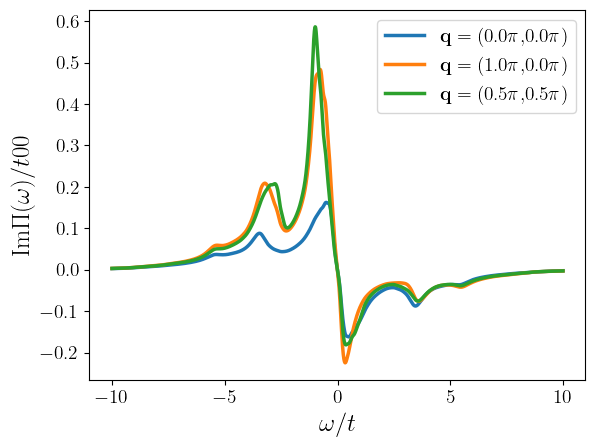

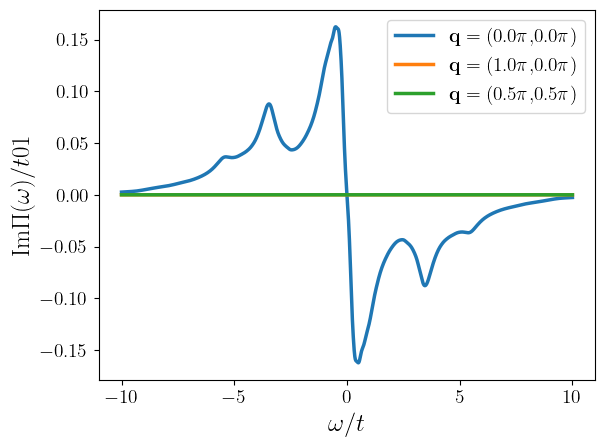

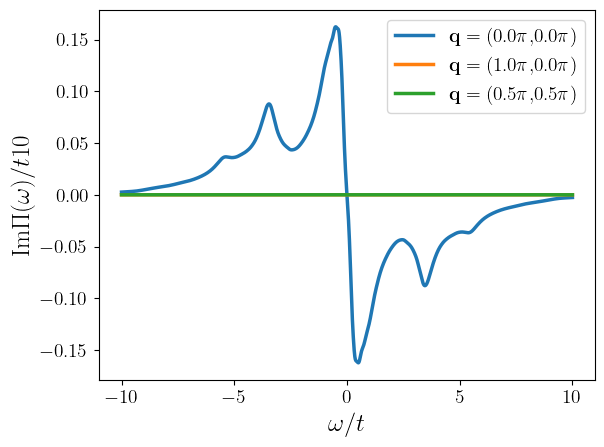

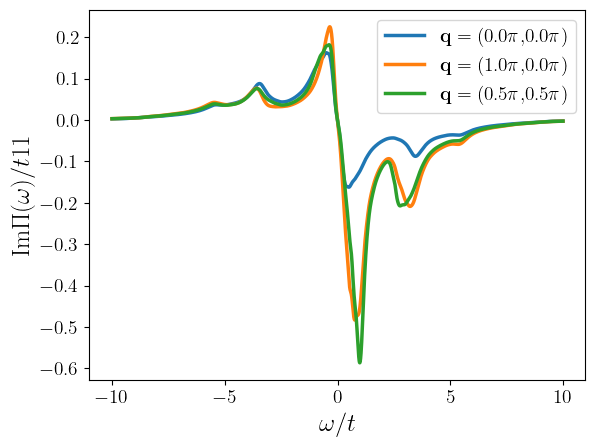

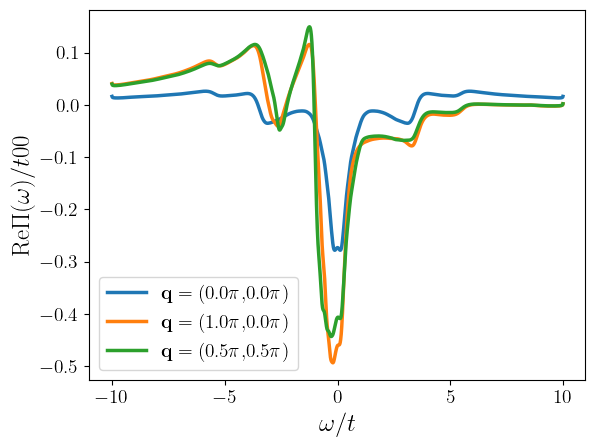

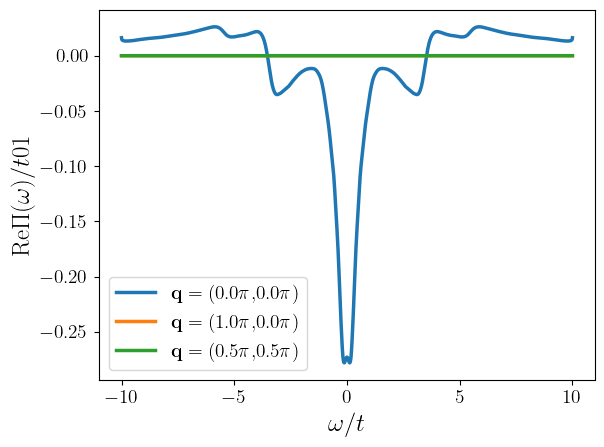

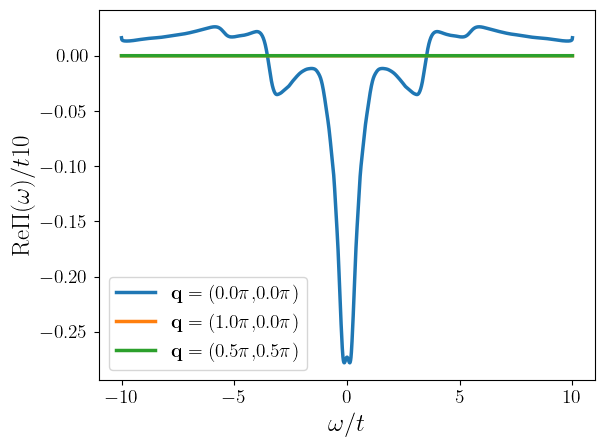

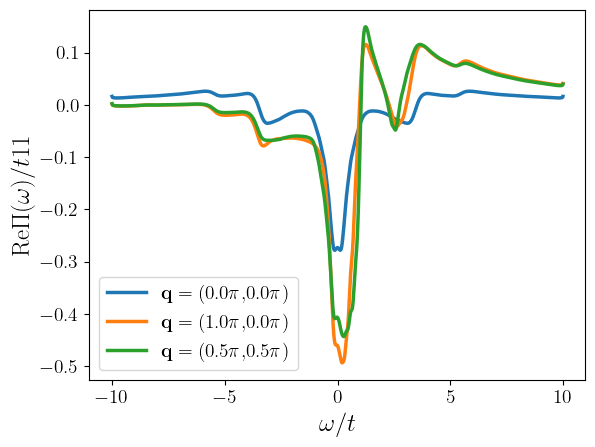

In [85]:
### Spectral function frequency cuts
indices = [[0,0],[8,0],[4,4]]
label_strings = [ r'$\mathbf{q}=($'+"{qx:0.1f}".format(qx=(f_spec.kxs[i[0]])/np.pi) + r'$\pi,$' + "{qy:0.1f}".format(qy=(f_spec.kys[i[1]])/np.pi) + r'$\pi)$'  for i in indices]

for a in range(2):
    for b in range(2):
        for j in range(len(indices)):
            i = indices[j]
            plt.plot(rpa.gen_magnon_freqs(f_spec.ws)/rpa.t, np.imag(Pi[a,b,i[0],i[1],:])/rpa.t,label=label_strings[j])#,color=clrs[j])
        plt.xlabel(r'$\omega/t$')
        plt.ylabel(r'Im$\Pi(\omega)/t$'+str(a)+str(b))
        plt.legend()
        #plt.xlim(-6,6)
        if saveFigs: plt.savefig(figDirectory+"/ImPi"+str(a)+str(b)+"_Jh=0.5_"+"delta={d:0.1%}_T={t:0.2f}.png".format(d=delta,t=T),bbox_inches='tight',transparent=True)
        plt.show()

for a in range(2):
    for b in range(2):
        for j in range(len(indices)):
            i = indices[j]
            plt.plot(rpa.gen_magnon_freqs(f_spec.ws)/rpa.t, np.real(Pi[a,b,i[0],i[1],:])/rpa.t,label=label_strings[j])#,color=clrs[j])
        plt.xlabel(r'$\omega/t$')
        plt.ylabel(r'Re$\Pi(\omega)/t$'+str(a)+str(b))
        plt.legend()
        #plt.xlim(-6,6)
        if saveFigs: plt.savefig(figDirectory+"/RePi"+str(a)+str(b)+"_Jh=0.5_"+"delta={d:0.1%}_T={t:0.2f}.png".format(d=delta,t=T),bbox_inches='tight',transparent=True)
        plt.show()

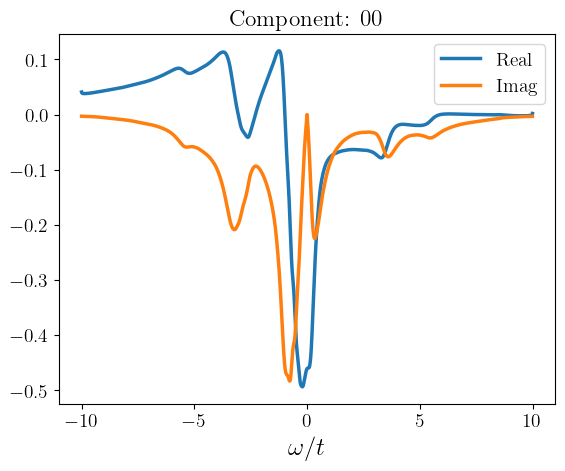

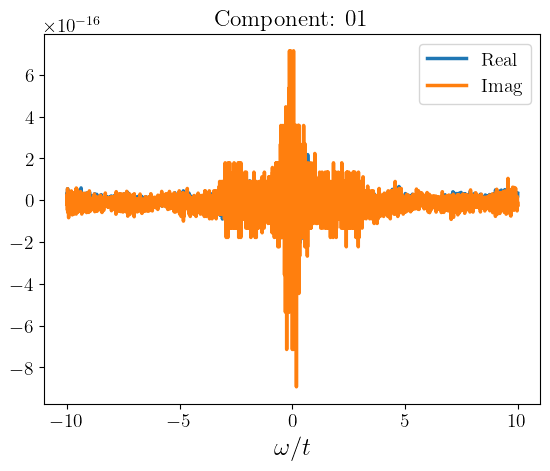

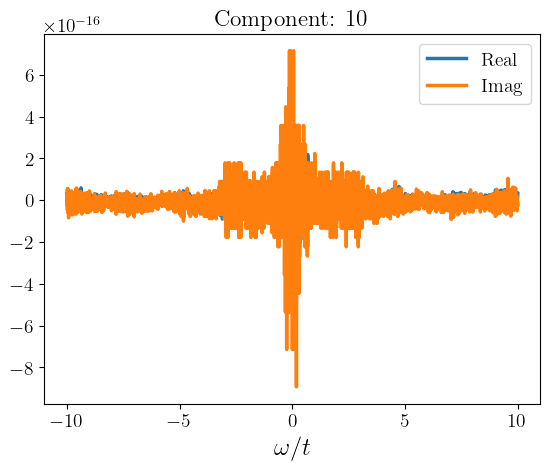

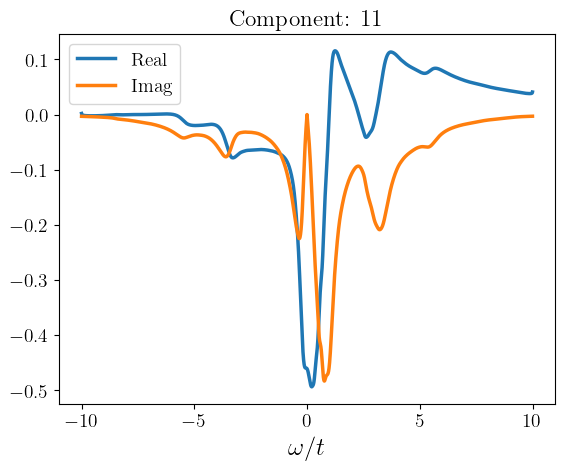

In [86]:
### Spectral function frequency cuts
indices = [[8,0]]
label_strings = [ r'$\mathbf{q}=($'+"{qx:0.1f}".format(qx=f_spec.kxs[i[0]]/np.pi) + r'$\pi,$' + "{qy:0.1f}".format(qy=f_spec.kys[i[1]]/np.pi) + r'$\pi)$'  for i in indices]
for j in range(len(indices)):
    i = indices[j]
    for a in range(2):
        for b in range(2):
            plt.plot(rpa.gen_magnon_freqs(f_spec.ws)/rpa.t, np.real(Pi[a,b,i[0],i[1],:])/rpa.t,label="Real")
            plt.plot(rpa.gen_magnon_freqs(f_spec.ws)/rpa.t, np.sign(rpa.gen_magnon_freqs(f_spec.ws))*np.imag(Pi[a,b,i[0],i[1],:])/rpa.t,label="Imag")
            plt.xlabel(r'$\omega/t$')
            #plt.xlim(-6,6)
            plt.title("Component: "+str(a)+str(b))
            plt.legend()
    
            plt.show()

In [87]:
### Spectral function frequency cuts

indices = [[0,0],[5,0],[10,0],[20,0],[10,10]]
#clrs = cmaps['magma'](np.linspace(0.,0.7,len(indices)))
label_strings = [ r'$\mathbf{q}=($'+"{qx:0.1f}".format(qx=kxs[i[0]]/np.pi) + r'$\pi,$' + "{qy:0.1f}".format(qy=kys[i[1]]/np.pi) + r'$\pi)$'  for i in indices]

for j in range(len(indices)):
    i = indices[j]
    print(kxs[i[0]]/np.pi,kys[i[1]]/np.pi)
    print(np.sum(spectrum[i[0],i[1],:])*dw)
    plt.plot(rpa.gen_magnon_freqs(ws)/J, spectrum[i[0],i[1],:],label=label_strings[j])
plt.axvline(2.,linestyle='dashed',color='gray')
plt.axvline(-2.,linestyle='dashed',color='gray')
plt.xlabel(r'$\omega/J$')
plt.ylabel(r'$S(\omega,\mathbf{q})/J$')
plt.legend()
plt.xlim(-10.,10.)
#plt.yscale('log')
plt.show()


NameError: name 'kxs' is not defined

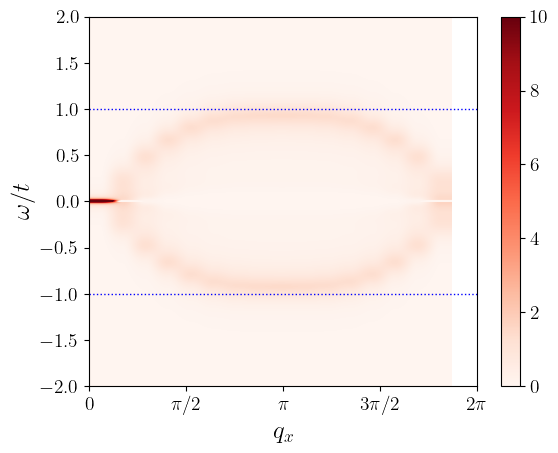

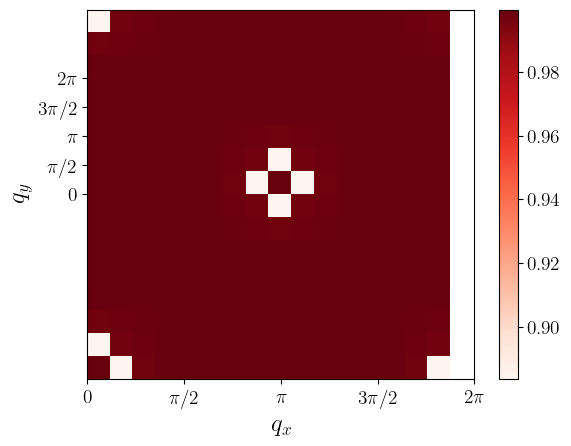

In [90]:
scale = mclr.LogNorm()
scale = mclr.Normalize(0.,10.)

plt.imshow(np.transpose(spectrum[:,0,:]),origin='lower',extent=[f_spec.kxs[0],f_spec.kxs[-1],f_spec.ws[0],f_spec.ws[-1]],cmap='Reds',aspect=1.5,norm=scale)
plt.ylabel(r'$\omega/t$')
plt.ylim(-2,2)
plt.xlabel(r'$q_x$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.colorbar()
#plt.title(r'$\delta = $'+"{:0.1%}".format(delta)+r'$T/t = $'+"{:0.2f}".format(T))
plt.axhline(2.*J,linestyle='dotted',color='blue',linewidth=1.)
plt.axhline(-2.*J,linestyle='dotted',color='blue',linewidth=1.)
if saveFigs: plt.savefig(figDirectory+"/spectrum_Jh=0.5_"+"delta={d:0.1%}_T={t:0.2f}.png".format(d=delta,t=T),bbox_inches='tight',transparent=True)
plt.show()

#scale = mclr.Normalize(0.,1.)
scale=None
plt.imshow(np.transpose(np.sum(spectrum,axis=-1)*np.real(f_spec.dw)),origin='lower',extent=[f_spec.kxs[0],f_spec.kxs[-1],f_spec.ws[0],f_spec.ws[-1]],aspect=0.3,cmap='Reds',norm=scale)
plt.xlabel(r'$q_x$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.ylabel(r'$q_y$')
plt.yticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.colorbar()
#plt.title(r'$\delta = $'+"{:0.1%}".format(delta))
if saveFigs: plt.savefig(figDirectory+"/sum_rule_Jh=0.5_"+"delta={d:0.1%}_T={t:0.2f}.png".format(d=delta,t=T),bbox_inches='tight',transparent=True)
plt.show()
